In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [183]:
class LinBandit:
    def __init__(self, theta = None, sigma = None, n_action = None):
        ## initialize a bandit model with parameters theta and phi
        ## r = <theta_a, s> + eta, eta~N(0, sigma^2)
        ## theta: array, each column is a theta_a value
        ## n_action: number of actions of the bandit
        self.theta = theta
        self.sigma = sigma
        self.n_action = n_action
        if theta is None:
            self.dim = None
        else:
            self.dim = theta.shape[0]
            self.n_action = theta.shape[1]
      
    def mean_reward(self, s, a):
        ## compute mean reward from input state s and a
        theta = self.theta
        if (theta is None) or (a > theta.shape[1]-1):
            return(None)
        theta_a = self.theta[:, a]
        mu = np.dot(theta_a, s) 
        return(mu)
    
    def realized_reward(self, s, a):
        ## compute realized reward from input state s and a
        sigma = self.sigma
        eta = np.random.normal(0, sigma)
        mu = self.mean_reward(s, a)
        if mu is None:
            return(None)
        r = self.mean_reward(s, a) + eta
        return(r)
        
    def generate_potential_reward_history_list(self, x_list, Sigma_e_list, dist_ops = 0., rho = 0.9):
        ## generate potential reward history (with oracle at) for given context with meas. err. w. known variance
        ## input: bandit instance, 
        ##        x_list: (context list), T*d
        ##        Sigma_e_list: (list of meas. err.), T * d * d
        ##        dist_ops: distribution of meas. err. 
        ##                  0: mv normal, 
        ##                  >2: t distribution with ? parameter, 
        ##                  -1: d = 1, uniform from {-rho, rho})
        ## output: x_list, Sigma_e_list,
        ##         x_tilde_list: revealed context list, T*d, gaussian meas. err.!
        ##         potential_reward_list: potential observed reward given each action, T * n_action
        ##         at_dag_list: oracle action 
        theta = self.theta
        d = self.dim
        n_action = self.n_action
        T = x_list.shape[0]
        if (theta is None):
            return(None)
        x_tilde_list = np.zeros((T, d))
        potential_reward_list = np.zeros((T, n_action))
        at_dag_list = np.zeros(T)
        for t in range(T):
            Sigma_e_t = Sigma_e_list[t, :, :]
            if (dist_ops == 0):
                x_tilde_t = x_list[t, :] + np.random.multivariate_normal(mean=np.zeros(d), cov=Sigma_e_t)
                x_tilde_list[t, :] = x_tilde_t
            elif (dist_ops == -1):
                x_tilde_t = x_list[t, :] + 2 * rho * np.random.binomial(1, 0.5) - rho
                x_tilde_list[t, :] = x_tilde_t
            else:
                nu = dist_ops
                Y = np.random.multivariate_normal(mean=np.zeros(d), cov=(nu-2)/nu*Sigma_e_t)
                U = np.random.chisquare(df = nu)
                x_tilde_t = x_list[t, :] + np.sqrt(nu / U) * Y
                x_tilde_list[t, :] = x_tilde_t
            for a in range(n_action):
                potential_reward_list[t, a] = self.realized_reward(x_list[t, :], a)
            mean_reward_dag = np.matmul(x_tilde_t.reshape((1, d)), theta).reshape(n_action)
            at_dag_list[t] = np.argmax(mean_reward_dag)
        return_list = {
            "x_list": x_list,
            "Sigma_e_list": Sigma_e_list,
            "x_tilde_list": x_tilde_list,
            "potential_reward_list": potential_reward_list,
            "at_dag_list": at_dag_list
        }
        return(return_list)
    
    def generate_potential_reward_history_list1(self, x_list, rho = 0.9):
        ## generate potential reward history (with oracle at) for given context with meas. err. w. known variance
        ## intended for constructing a counterexample s.t. Ass. 2.3 holds, naive UCB/TS has linear regret
        ## input: bandit instance, 
        ##        x_list: (context list), T*d
        ## output: x_list, Sigma_e_list,
        ##         x_tilde_list: revealed context list, T*d
        ##         potential_reward_list: potential observed reward given each action, T * n_action
        ##         at_dag_list: oracle action 
        theta = self.theta
        d = self.dim
        n_action = self.n_action
        T = x_list.shape[0]
        if (theta is None):
            return(None)
        x_tilde_list = np.zeros((T, d))
        potential_reward_list = np.zeros((T, n_action))
        at_dag_list = np.zeros(T)
        for t in range(T):
            # generate e_t and x_tilde_list[t, :] = x_tilde_t
            e_sign = np.random.binomial(1, 0.5) * 2 - 1
            e1 = e_sign * rho * x_list[t, 0]
            x_tilde_t = x_list[t, :] + e1 * np.ones(d)
            x_tilde_list[t, :] = x_tilde_t
            
            for a in range(n_action):
                potential_reward_list[t, a] = self.realized_reward(x_list[t, :], a)
            mean_reward_dag = np.matmul(x_tilde_t.reshape((1, d)), theta).reshape(n_action)
            at_dag_list[t] = np.argmax(mean_reward_dag)
        
        return_list = {
            "x_list": x_list,
            #"Sigma_e_list": Sigma_e_list,
            "x_tilde_list": x_tilde_list,
            "potential_reward_list": potential_reward_list,
            "at_dag_list": at_dag_list
        }
        return(return_list) 
    
    def generate_potential_reward_history_list_w_xtilde(self, x_list, x_tilde_list):
        ## generate potential reward history with both list of x and x_tilde 
        ## input: bandit instance, 
        ##        x_list: (context list), T*d
        ##        x_tilde_list: list of predicted context list, T*d
        ## output: x_list, Sigma_e_list,
        ##         x_tilde_list: revealed context list, T*d
        ##         potential_reward_list: potential observed reward given each action, T * n_action
        ##         at_dag_list: oracle action 
        theta = self.theta
        d = self.dim
        n_action = self.n_action
        T = x_list.shape[0]
        if (theta is None):
            return(None)
        potential_reward_list = np.zeros((T, n_action))
        at_dag_list = np.zeros(T)
        for t in range(T):
            x_tilde_t = x_tilde_list[t, :]
            
            for a in range(n_action):
                potential_reward_list[t, a] = self.realized_reward(x_list[t, :], a)
            mean_reward_dag = np.matmul(x_tilde_t.reshape((1, d)), theta).reshape(n_action)
            at_dag_list[t] = np.argmax(mean_reward_dag)
        
        return_list = {
            "x_list": x_list,
            #"Sigma_e_list": Sigma_e_list,
            "x_tilde_list": x_tilde_list,
            "potential_reward_list": potential_reward_list,
            "at_dag_list": at_dag_list
        }
        return(return_list) 
        

    def TS_w_predicted_state(self, x_list, x_tilde_list, potential_reward_list, \
                             at_dag_list, rho2, l = 1., p_0 = 0.2, x_tilde_test = None):
        ## runs the TS algorithm on the bandit instance with hyperparameters rho2, l, p_0, ignoring meas. err.
        ##          p_0: minimum selection probability
        ##          rho2: parameter for TS - known noise variance in the reward model
        ##          l: parameter for TS - prior variance independent rho^2 / l
        ##          x_tilde_list: list of predicted contexts
        ##          potential_reward_list: list of potential reward (to compare with other algorithms)
        ##          x_tilde_test: value of x_tilde to evaluate the action selection probability, d dimensional
        ##                        (to evaluate convergence of policy at specific value of x_tilde)
        ## returns: estimation_err_list, cumulative_regret
        ##          history also contains: x_tilde_list, potential_reward_list, at_dag_list,
        ##          theta_est_list: all estimated theta (posterior mean), n_action * T * d
        ##          pi_list: policy, T * n_action
        ##          at_list: action, T
        ##          cumulative_regret = \sum_t [E_{pi_t_dag}mu(x_t, a) - E_{pi_t}mu(x_t, a)]
        ##          pi_list_test: policy if x_tilde = x_tilde_test, T * n_action
        d = self.dim
        T = x_list.shape[0]
        theta = self.theta
        n_action = self.n_action
        if (n_action != 2):
            return(None)
        
        ## initialization of returned values
        theta_est_list = np.zeros((n_action, T, d)) 
        pi_list = np.zeros((T, n_action))
        at_list = np.zeros(T)
        estimation_err_list = np.zeros((T, n_action))
        regret_list = np.zeros(T)
        pi_list_test = np.zeros((T, n_action)) 
        
        ## algorithm initialization
        regret = 0. # cumulative regret up to current time
        Vt = np.zeros((n_action, d, d))  # Vt[a, :, :] = l * I + sum_{\tau<t} 1_{A_\tau = a}\tilde X_\tau \tilde X_\tau^\top
        for a in range(n_action):
            Vt[a, :, :] = l * np.eye(d)
        bt = np.zeros((n_action, d)) # bt[a, :] = sum_{\tau<t} 1_{A_\tau = a}\tilde X_\tau r_\tau
        t = 0 # current time (from 0 to T-1)
        
        ## algorithm iterations
        while t < T:
            x_tilde_t = x_tilde_list[t, :]
            x_t = x_list[t, :]
            
            ## compute posterior mean/var for all actions using Vt, bt
            post_mean_t = np.zeros((n_action, d))
            post_var_t = np.zeros((n_action, d, d))
            for a in range(n_action):
                post_mean = np.matmul(np.linalg.inv(Vt[a, :, :]), bt[a, :])
                post_mean_t[a, :] = post_mean
                post_var_t[a, :, :] = rho2 * np.linalg.inv(Vt[a, :, :])
                theta_est_list[a, t, :] = post_mean
                estimation_err_list[t, a] = np.linalg.norm(post_mean - theta[:, a])
            
            ## compute the probability theta_0 drawn is more optimal, adjust with clipping probability to form pi_t_0
            # compute mean and var of <x_tilde_t, theta_0-theta_1> when thetas drawn from the posteriors
            post_mean_w_x_tilde = np.dot(x_tilde_t, post_mean_t[0, :] - post_mean_t[1, :])
            post_var_w_x_tilde = np.dot(x_tilde_t, np.matmul(post_var_t[0, :, :] + post_var_t[1, :, :], x_tilde_t))
            prob_0 = 1 - stats.norm.cdf(-post_mean_w_x_tilde / np.sqrt(post_var_w_x_tilde))  # the probability of sampling 0 without clipping constraint
            pi_0 = prob_clip(prob_0, p_0) # clipped probability of sampling 0
            pi_list[t, 0] = pi_0
            pi_list[t, 1] = 1 - pi_0
            #if (at_dag_list[t] == 0):   # given Ass. 2.3, at_dag=at_star
            if (np.dot(x_t, theta[:, 0]) > np.dot(x_t, theta[:, 1])):
                regret_t = np.dot(x_t, theta[:, 0] - theta[:, 1]) * (1 - p_0 - pi_0) # instantaneous regret
            else:
                regret_t = np.dot(x_t, theta[:, 1] - theta[:, 0]) * (pi_0 - p_0)
            regret = regret + regret_t  # update cumulative regret
            regret_list[t] = regret
            
            ## compute the probability 0 is optimal if x_tilde is x_tilde_test
            if x_tilde_test is not None:
                post_mean_w_x_tilde_test = np.dot(x_tilde_test, post_mean_t[0, :] - post_mean_t[1, :])
                post_var_w_x_tilde_test = np.dot(x_tilde_test, np.matmul(post_var_t[0, :, :] + post_var_t[1, :, :], x_tilde_test))
                prob_0_test = 1 - stats.norm.cdf(-post_mean_w_x_tilde_test / np.sqrt(post_var_w_x_tilde_test))  # the probability of sampling 0 without clipping constraint
                pi_0_test = prob_clip(prob_0_test, p_0) # clipped probability of sampling 0
                #print(pi_0_test)
                pi_list_test[t, 0] = pi_0_test
                pi_list_test[t, 1] = 1 - pi_0_test
            
            ## sample from pi_t to obtain a_t, observe reward
            at = np.random.binomial(1, 1 - pi_0) 
            at_list[t] = at
            rt = potential_reward_list[t, at]
            
            ## update Vt, bt for all actions (only posterior w. action a is changed)
            Vt[at, :, :] = Vt[at, :, :] + np.matmul(x_tilde_t.reshape((d, 1)), x_tilde_t.reshape((1, d)))
            bt[at, :] = bt[at, :] + x_tilde_t * rt

            ## update t
            t = t + 1
        
        ## history construction
        history = {
            "x_list": x_list,
            "x_tilde_list": x_tilde_list,
            "potential_reward_list": potential_reward_list,
            "at_dag_list": at_dag_list,
            "theta_est_list": theta_est_list,
            "at_list": at_list,
            "pi_list": pi_list,
            "estimation_err_list": estimation_err_list,
            "regret_list": regret_list,
            "pi_list_test": pi_list_test
        }
        return(history)    

    
    def UCB_w_predicted_state(self, x_list, x_tilde_list, potential_reward_list, at_dag_list, C, \
                              l = 1., p_0 = 0.2, x_tilde_test = None):
        ## runs the UCB algorithm on the bandit instance with hyperparameters C, l, p_0, ignoring meas. err.
        ##          p_0: minimum selection probability
        ##          C: parameter for UCB - coefficient before confidence width in UCB
        ##          l: parameter for UCB - parameter in ridge regression
        ##          x_tilde_list: list of predicted contexts
        ##          potential_reward_list: list of potential reward (to compare with other algorithms)
        ##          x_tilde_test: value of x_tilde to evaluate the action selection probability, d dimensional
        ##                        (to evaluate convergence of policy at specific value of x_tilde)
        ## returns: estimation_err_list, cumulative_regret
        ##          history also contains: x_tilde_list, potential_reward_list, at_dag_list,
        ##          theta_est_list: all estimated theta (posterior mean), n_action * T * d
        ##          pi_list: policy, T * n_action
        ##          at_list: action, T
        ##          cumulative_regret = \sum_t [E_{pi_t_dag}mu(x_t, a) - E_{pi_t}mu(x_t, a)]
        ##          pi_list_test: policy if x_tilde = x_tilde_test, T * n_action
        d = self.dim
        T = x_list.shape[0]
        theta = self.theta
        n_action = self.n_action
        if (n_action != 2):
            return(None)
        
        ## initialization of returned values
        theta_est_list = np.zeros((n_action, T, d)) 
        pi_list = np.zeros((T, n_action))
        at_list = np.zeros(T)
        estimation_err_list = np.zeros((T, n_action))
        regret_list = np.zeros(T)
        pi_list_test = np.zeros((T, n_action))
        
        ## algorithm initialization
        regret = 0. # cumulative regret up to current time
        Vt = np.zeros((n_action, d, d))  # Vt[a, :, :] = l * I + sum_{\tau<t} 1_{A_\tau = a}\tilde X_\tau \tilde X_\tau^\top
        for a in range(n_action):
            Vt[a, :, :] = l * np.eye(d)
        bt = np.zeros((n_action, d)) # bt[a, :] = sum_{\tau<t} 1_{A_\tau = a}\tilde X_\tau r_\tau
        t = 0 # current time (from 0 to T-1)
        
        ## algorithm iterations
        while t < T:
            x_tilde_t = x_tilde_list[t, :]
            x_t = x_list[t, :]
            
            ## compute best action using Vt, bt, update estimation error
            UCB_list = np.zeros(n_action)
            for i_action in range(n_action):
                theta_a_hat = np.matmul(np.linalg.inv(Vt[i_action, :, :]), bt[i_action, :].reshape((d, 1))).reshape(d)
                mu_a = np.dot(theta_a_hat, x_tilde_t)
                sigma_a2 = np.dot(x_tilde_t, np.matmul(np.linalg.inv(Vt[i_action, :, :]), x_tilde_t))
                UCB_list[i_action] = mu_a + C * np.sqrt(sigma_a2)
                theta_est_list[i_action, t, :] = theta_a_hat
                estimation_err_list[t, i_action] = np.linalg.norm(theta_a_hat - theta[:, i_action])
            at_ucb = np.argmax(UCB_list)  # best action from UCB
            
            ## compute current policy pi_t, adjust with clipping, compute regret
            for i_action in range(n_action):
                if (i_action == at_ucb):
                    pi_list[t, i_action] = 1 - (n_action - 1) * p_0
                else:
                    pi_list[t, i_action] = p_0
            
            ## compute policy at x_tilde_test
            if x_tilde_test is not None:
                UCB_list_test = np.zeros(n_action)
                for i_action in range(n_action):
                    theta_a_hat = np.matmul(np.linalg.inv(Vt[i_action, :, :]), bt[i_action, :].reshape((d, 1))).reshape(d)
                    mu_a_test = np.dot(theta_a_hat, x_tilde_test)
                    sigma_a2_test = np.dot(x_tilde_test, np.matmul(np.linalg.inv(Vt[i_action, :, :]), x_tilde_test))
                    UCB_list_test[i_action] = mu_a_test + C * np.sqrt(sigma_a2_test)
                at_ucb_test = np.argmax(UCB_list_test)
                for i_action in range(n_action):
                    if (i_action == at_ucb_test):
                        pi_list_test[t, i_action] = 1 - (n_action - 1) * p_0
                    else:
                        pi_list_test[t, i_action] = p_0
            
            #if (at_dag_list[t] == 0):   # given Ass. 2.3, at_dag=at_star
            if (np.dot(x_t, theta[:, 0]) > np.dot(x_t, theta[:, 1])): # reward of oracle policy
                reward_oracle_t = np.dot(x_t, theta[:, 0]) * (1 - p_0) \
                                  + np.dot(x_t, theta[:, 1]) * p_0        # oracle instantaneous reward
            else:
                reward_oracle_t = np.dot(x_t, theta[:, 1]) * (1 - p_0) \
                                  + np.dot(x_t, theta[:, 0]) * p_0
            reward_policy = np.dot(x_t, theta[:, 0]) * pi_list[t, 0] \
                            + np.dot(x_t, theta[:, 1]) * pi_list[t, 1]    # reward of current policy
            regret_t = reward_oracle_t - reward_policy   # instantaneous regret
            regret = regret + regret_t
            regret_list[t] = regret
            
            ## sample from pi_t to obtain a_t, observe reward
            at = np.random.binomial(1, pi_list[t, 1]) 
            at_list[t] = at
            rt = potential_reward_list[t, at]  
            
            ## update Vt, bt for all actions (only data w. action a is changed)
            Vt[at, :, :] = Vt[at, :, :] + np.matmul(x_tilde_t.reshape((d, 1)), x_tilde_t.reshape((1, d)))
            bt[at, :] = bt[at, :] + x_tilde_t * rt

            ## update t
            t = t + 1
        
        ## history construction
        history = {
            "x_list": x_list,
            "x_tilde_list": x_tilde_list,
            "potential_reward_list": potential_reward_list,
            "at_dag_list": at_dag_list,
            "theta_est_list": theta_est_list,
            "at_list": at_list,
            "pi_list": pi_list,
            "estimation_err_list": estimation_err_list,
            "regret_list": regret_list,
            "pi_list_test": pi_list_test
        }
        return(history) 
    
    def online_me_adjust_w_predicted_state(self, x_list, x_tilde_list, potential_reward_list, at_dag_list, \
                                           Sigma_e_hat_list, ind_S, pi_nd_list, p_0 = 0.2, naive = False,\
                                           x_tilde_test = None):
        ## runs the online meas. adjust algorithm on the bandit instance with hyperparameters Sigma_e_hat_list, p_0, ind_S, pi_nd_list
        ##          p_0: minimum selection probability
        ##          ind_S: binary vector indicating if algorithm update model estimate
        ##          pi_nd_list: stablizing policy, T * n_action
        ##          Sigma_e_hat_list: estimated conditional var of meas. err
        ##          x_list: list of true underlying contexts
        ##          x_tilde_list: list of predicted contexts
        ##          potential_reward_list: list of potential reward (to compare with other algorithms)
        ##          x_tilde_test: value of x_tilde to evaluate the action selection probability, d dimensional
        ##                        (to evaluate convergence of policy at specific value of x_tilde)
        ## returns: estimation_err_list, cumulative_regret
        ##          history also contains: x_tilde_list, potential_reward_list, at_dag_list,
        ##          theta_est_list: all estimated theta (posterior mean), n_action * T * d
        ##          pi_list: policy, T * n_action
        ##          at_list: action, T
        ##          cumulative_regret = \sum_t [E_{pi_t_dag}mu(x_t, a) - E_{pi_t}mu(x_t, a)]
        ##          pi_list_test: policy if x_tilde = x_tilde_test, T * n_action
        d = self.dim
        T = x_list.shape[0]
        theta = self.theta
        n_action = self.n_action
        
        ## initialization of returned values
        theta_est_list = np.zeros((n_action, T, d)) 
        pi_list = np.zeros((T, n_action))
        at_list = np.zeros(T)
        estimation_err_list = np.zeros((T, n_action))
        regret_list = np.zeros(T)
        pi_list_test = np.zeros((T, n_action))
        
        ## algorithm initialization
        t = 0
        s_t = -1  # s_t: the most recent update index before time t
        V_t = np.zeros((n_action, d, d))  # Vt = \sum_{\tau<t} iw_\tau * 1_{a_\tau = a} * x_tilde_\tau x_tilde_\tau^\top, iw_t = \pi^nd_t(a_t)/\pi_t(a_t)
        W_t = np.zeros((n_action, d, d))  # Wt = \sum_{\tau<t} \pi_\tau^nd(a) * Sigma_e_hat[\tau, :, :]
        b_t = np.zeros((n_action, d))  # bt = \sum_{\tau<t} iw_\tau * 1_{a_\tau = a} * x_tilde_\tau r_\tau
        V_st = np.zeros((n_action, d, d))  # most recent recorded V_t
        W_st = np.zeros((n_action, d, d))  # most recent recorded W_t
        b_st = np.zeros((n_action, d))  # most recent recorded b_t
        theta_st = np.zeros((n_action, d))  # most recent estimated theta
        regret = 0.  # cumulative regret
        
        ## algorithm iterations
        while t<T:
            x_tilde_t = x_tilde_list[t, :]
            x_t = x_list[t, :]
            
            ## get most recent theta estimation, compute policy and regret
            if (s_t < 0): # no theta available, take theta=0
                pi_t_0 = .5
                pi_t_1 = .5
                pi_list[t, 0] = pi_t_0
                pi_list[t, 1] = pi_t_1
                if x_tilde_test is not None:
                    pi_list_test[t, 0] = pi_t_0
                    pi_list_test[t, 1] = pi_t_1
            else:
                at_tilde = np.argmax(np.matmul(theta_st, x_tilde_t))
                pi_list[t, at_tilde] = 1 - p_0
                pi_list[t, 1-at_tilde] = p_0
                if x_tilde_test is not None:
                    at_tilde_test = np.argmax(np.matmul(theta_st, x_tilde_test))
                    pi_list_test[t, at_tilde_test] = 1 - p_0
                    pi_list_test[t, 1-at_tilde_test] = p_0
            # compute regret (defined with x_t, not x_tilde_t!)
            #if (at_dag_list[t] == 0):   # given Ass. 2.3, at_dag=at_star
            if (np.dot(x_t, theta[:, 0]) > np.dot(x_t, theta[:, 1])):
                reward_oracle_t = np.dot(x_t, theta[:, 0]) * (1 - p_0) \
                                  + np.dot(x_t, theta[:, 1]) * p_0        
            else:
                reward_oracle_t = np.dot(x_t, theta[:, 1]) * (1 - p_0) \
                                  + np.dot(x_t, theta[:, 0]) * p_0
            reward_policy = np.dot(x_tilde_t, theta[:, 0]) * pi_list[t, 0] \
                            + np.dot(x_tilde_t, theta[:, 1]) * pi_list[t, 1]    # reward of current policy
            regret_t = reward_oracle_t - reward_policy   # instantaneous regret
            regret = regret + regret_t
            regret_list[t] = regret
            
            ## sample action, observe reward
            at = np.random.binomial(1, pi_list[t, 1]) 
            at_list[t] = at
            rt = potential_reward_list[t, at]          
            
            ## record theta
            for a in range(n_action):
                theta_est_list[a, t, :] = theta_st[a, :]
                estimation_err_list[t, a] = np.linalg.norm(theta_st[a, :] - theta[:, a])
            
            ## update V, W, b; most recent V, W, b; s_t, theta_st
            if (naive == False):
                imp_weight_at = pi_nd_list[t, at] / pi_list[t, at]
            else:
                imp_weight_at = 1.
            for a in range(n_action):
                # update V and b
                if (a == at):
                    V_t[a, :, :] = V_t[a, :, :] + imp_weight_at * np.matmul(x_tilde_t.reshape((d, 1)), x_tilde_t.reshape((1, d)))
                    b_t[a, :] = b_t[a, :] + imp_weight_at * x_tilde_t * rt
                # update W
                if (naive == False):
                    W_t[a, :, :] = W_t[a, :, :] + pi_nd_list[t, a] * Sigma_e_hat_list[t, :, :]
                elif (a == at):
                    W_t[a, :, :] = W_t[a, :, :] + Sigma_e_hat_list[t, :, :]
            if (ind_S[t] == 1):
                s_t = t
                V_st = V_t
                b_st = b_t
                W_st = W_t
                for a in range(n_action):
                    theta_st[a, :] = np.matmul(np.linalg.pinv(V_st[a, :, :] - W_st[a, :, :]), b_st[a, :])
            
            ## update t
            t = t + 1
        
        ## history construction
        history = {
            "x_list": x_list,
            "x_tilde_list": x_tilde_list,
            "potential_reward_list": potential_reward_list,
            "at_dag_list": at_dag_list,
            "theta_est_list": theta_est_list,
            "at_list": at_list,
            "pi_list": pi_list,
            "estimation_err_list": estimation_err_list,
            "regret_list": regret_list,
            "pi_list_test": pi_list_test
        }
        return(history)    

In [184]:
## utility functions
def prob_clip(x, p_0):
    ## clip the probability value x to be between [p_0, 1-p_0]
    ## require 0<=p_0<=1/2
    if (x < p_0):
        return(p_0)
    if (x > (1-p_0)):
        return(1-p_0)
    return(x)

def weighted_theta_est(history, pi_nd, Sigma_e):
    ## calculate the weighted estimator for thetas given a bandit history data, with iid potential outcome
    ## history MUST be a dictionary containing the following entries:
    ##         'x_list': list of true underlying context, T*d
    ##         'x_tilde_list': list of predicted context list, T*d
    ##         'at_list': list of selected actions, T dimensional
    ##         'pi_list': list of action selection probabilities, T * n_action
    ##         'potential_reward_list': list of all potential rewards, T * n_action
    ##         'theta_est_list': list of estimators of thetas during the online algorithm, n_action * T * d
    ## pi_nd: (stationary) stablizing policy, n_action dimensional
    ## Sigma_e: covariance matrix of the measurement error, d * d
    ## OUTPUT: theta_est_batch: weighted estimators of theta with the batch data, n_action * d
    
    ## extract information
    x_list = history['x_list']
    x_tilde_list = history['x_tilde_list']
    at_list = history['at_list']
    pi_list = history['pi_list']
    potential_reward_list = history['potential_reward_list']
    if ('theta_est_list' in list(history.keys())):
        theta_est_list = history['theta_est_list']
    else:
        theta_est_list = None
    
    # initialization
    Ut = np.zeros((n_action, d, d)) # Ut[a, :, :] = \sum_t W_t1_{A_t=a}(x_tilde_t * x_tilde_t^T - Sigma_e)
    Vt = np.zeros((n_action, d)) # Vt[a, :, :] = \sum_t W_t1_{A_t=a} x_tilde_t * Y_t
    t = 0
    
    while (t<T):
        A_t = int(at_list[t])
        x_tilde_t = x_tilde_list[t, :]
        rt = potential_reward_list[t, A_t]
        
        ## extract importance weight for action a = A_t
        ipt_wt = pi_nd[A_t] / pi_list[t, A_t]
        
        ## update Ut for a = A_t
        Ut[A_t, :, :] = Ut[A_t, :, :] + ipt_wt * (np.matmul(x_tilde_t.reshape((d, 1)), x_tilde_t.reshape((1, d))) - Sigma_e)
        
        ## update Vt for a = A_t
        Vt[A_t, :] = Vt[A_t, :] + ipt_wt * x_tilde_t * rt
        
        ## update t
        t = t + 1
    
    ## compute weighted estimator theta_hat
    theta_est_batch = np.zeros((n_action, d))
    for a in range(n_action):
        theta_est_batch[a, :] = np.matmul(np.linalg.pinv(Ut[a, :, :]), Vt[a, :])
    
    return_list = {
            "theta_est_batch": theta_est_batch,
            "theta_est_list": theta_est_list
    }
    return(return_list)

simulation for 1d linear contextual bandit, test theta distribution

In [218]:
## simulation: test bandit behavior policy

T = 10000
d = 1
n_experiment = 100
n_action = 2
theta = np.zeros((d, n_action))
theta[:, 0] = np.array([-3.])
theta[:, 1] = np.array([-2.])
sigma = 0.01
p_0 = 0.2
pi_nd = np.array([0.5, 0.5])

## option: sample x and e from a known discrete distribution
x_dict = np.array([[0., -1]]).T  ## true context uniformly drawn from this distribution
e_dict = np.array([[1., -2],[-1, 2]])  ## according to x, e has distribution with support shown in the matrix
                                       ## in each row, first value sampled w.p. 1/3, second value sampled w.p. 2/3
Sigma_e = 2./3 * 1 + 1./3 * 4

theta_est_UCB = np.zeros((n_experiment, n_action, T, d))        ## records the running theta estimation for each trajectory
theta_est_TS = np.zeros((n_experiment, n_action, T, d))
theta_est_MEB = np.zeros((n_experiment, n_action, T, d))

pi_list_UCB = np.zeros((n_experiment, T, n_action))    ## records the running action selection probability for each trajectory
pi_list_TS = np.zeros((n_experiment, T, n_action))
pi_list_MEB = np.zeros((n_experiment, T, n_action))

theta_est_batch_UCB = np.zeros((n_experiment, n_action, d))        ## records the value of weighted theta estimation for each trajectory
theta_est_batch_TS = np.zeros((n_experiment, n_action, d))
theta_est_batch_MEB = np.zeros((n_experiment, n_action, d))
for i_experiment in range(n_experiment):
    if (i_experiment % 10 == 0):
        print(i_experiment, end = ' ')
    Bandit_1 = LinBandit(theta = theta, sigma = sigma)
    
    # generate x_t and x_t_tilde
    x_list = np.zeros((T, d)) 
    x_tilde_list = np.zeros((T, d)) 
    for t in range(T):
        ## option: sample x and e from a known discrete distribution
        x_idx = np.random.randint(0, 2)
        x_t = x_dict[x_idx, :]
        e_list = e_dict[x_idx, :]        ## list of possible values for e_t
        e_idx = stats.bernoulli.rvs(p = 1./3)
        e_t = e_list[e_idx]
        x_tilde_t = x_t + e_t
        x_list[t, :] = x_t
        x_tilde_list[t, :] = x_tilde_t
    
    # generate potential outcomes table
    Bandit_info = Bandit_1.generate_potential_reward_history_list_w_xtilde(x_list = x_list, \
                                                                           x_tilde_list = x_tilde_list)
    
    # run bandit algorithms
    C = 1.0
    UCB_history = Bandit_1.UCB_w_predicted_state(x_list = x_list,
                                                 x_tilde_list = x_tilde_list, \
                                                 potential_reward_list = Bandit_info['potential_reward_list'], \
                                                 at_dag_list = Bandit_info['at_dag_list'], \
                                                 C = C, l = 1., p_0 = p_0, \
                                                 x_tilde_test = np.array([1.]))
    TS_history = Bandit_1.TS_w_predicted_state(x_list = x_list,
                                               x_tilde_list = x_tilde_list, \
                                               potential_reward_list = Bandit_info['potential_reward_list'], \
                                               at_dag_list = Bandit_info['at_dag_list'], \
                                               rho2 = sigma ** 2, l = 1., p_0 = p_0, \
                                               x_tilde_test = np.array([1.]))
    
    ## construct parameters for MEB
    ind_S = (np.arange(T) > 200)
    pi_nd_list = 0.5 * np.ones((T, n_action))
    Sigma_e_hat_list = np.zeros((T, d, d))
    for t in range(T):
        Sigma_e_hat_list[t, :, :] = Sigma_e
    MEB_history = Bandit_1.online_me_adjust_w_predicted_state(x_list = x_list, x_tilde_list = x_tilde_list, \
                                                              potential_reward_list = Bandit_info['potential_reward_list'],  
                                                              at_dag_list = Bandit_info['at_dag_list'],\
                                                              Sigma_e_hat_list = Sigma_e_hat_list, \
                                                              ind_S = ind_S, 
                                                              pi_nd_list = pi_nd_list, \
                                                              p_0 = p_0, naive = False, \
                                                              x_tilde_test = np.array([1.]))
    
    # record running theta est
    theta_est_UCB[i_experiment, :, :, :] = UCB_history['theta_est_list'][:, :, :]
    theta_est_TS[i_experiment, :, :, :] = TS_history['theta_est_list'][:, :, :]
    theta_est_MEB[i_experiment, :, :, :] = MEB_history['theta_est_list'][:, :, :]
    
    # record action selection probability 
    pi_list_UCB[i_experiment, :, :] = UCB_history['pi_list_test']
    pi_list_TS[i_experiment, :, :] = TS_history['pi_list_test']
    pi_list_MEB[i_experiment, :, :] = MEB_history['pi_list_test']
    
    # get weighted_theta_est
    theta_est_UCB_results = weighted_theta_est(history = UCB_history, \
                                               pi_nd = pi_nd, \
                                               Sigma_e = Sigma_e)
    theta_est_batch_UCB[i_experiment, :, :] = theta_est_UCB_results['theta_est_batch']
    theta_est_TS_results = weighted_theta_est(history = TS_history, \
                                              pi_nd = pi_nd, \
                                              Sigma_e = Sigma_e)
    theta_est_batch_TS[i_experiment, :, :] = theta_est_TS_results['theta_est_batch']
    theta_est_MEB_results = weighted_theta_est(history = MEB_history, \
                                              pi_nd = pi_nd, \
                                              Sigma_e = Sigma_e)
    theta_est_batch_MEB[i_experiment, :, :] = theta_est_MEB_results['theta_est_batch']


0 10 20 30 40 50 60 70 80 90 

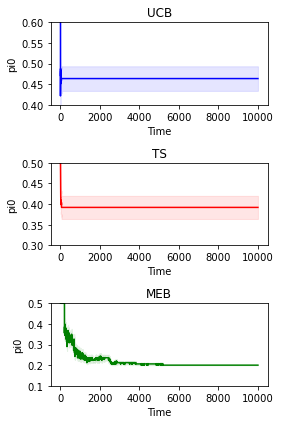

In [226]:
pi0_list_UCB = pi_list_UCB[:, :, 0]      ## extract prob of selecting action 0 over time for trajectories
pi0_list_TS = pi_list_TS[:, :, 0]
pi0_list_MEB = pi_list_MEB[:, :, 0]

means_pi0_UCB = np.mean(pi0_list_UCB, axis=0)
ses_pi0_UCB = np.std(pi0_list_UCB, axis=0) / np.sqrt(n_experiment)
means_pi0_TS = np.mean(pi0_list_TS, axis=0)
ses_pi0_TS = np.std(pi0_list_TS, axis=0) / np.sqrt(n_experiment)
means_pi0_MEB = np.mean(pi0_list_MEB, axis=0)
ses_pi0_MEB = np.std(pi0_list_MEB, axis=0) / np.sqrt(n_experiment)

# Plot mean and se of the estimated theta0 for all the algorithms
fig, axes = plt.subplots(3, 1, figsize=(4, 6))

# Plot for UCB
axes[0].plot(np.arange(1, T+1), means_pi0_UCB[:], color='blue', alpha=1, label='Mean')
axes[0].fill_between(np.arange(1, T+1), means_pi0_UCB[:] - ses_pi0_UCB[:], \
                     means_pi0_UCB[:] + ses_pi0_UCB[:], color='blue', alpha=0.1)
axes[0].set_title('UCB')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('pi0')
axes[0].set_ylim((0.4, 0.6))  # Set y-axis range

# Plot for TS
axes[1].plot(np.arange(1, T+1), means_pi0_TS[:], color='red', alpha=1, label='Mean')
axes[1].fill_between(np.arange(1, T+1), means_pi0_TS[:] - ses_pi0_TS[:], \
                     means_pi0_TS[:] + ses_pi0_TS[:], color='red', alpha=0.1)
axes[1].set_title('TS')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('pi0')
axes[1].set_ylim((0.3, 0.5))  # Set y-axis range

# Plot for MEB
axes[2].plot(np.arange(1, T+1), means_pi0_MEB[:], color='green', alpha=1, label='Mean')
axes[2].fill_between(np.arange(1, T+1), means_pi0_MEB[:] - ses_pi0_MEB[:], \
                     means_pi0_MEB[:] + ses_pi0_MEB[:], color='green', alpha=0.1)
axes[2].set_title('MEB')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('pi0')
axes[2].set_ylim((0.1, 0.5))  # Set y-axis range

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

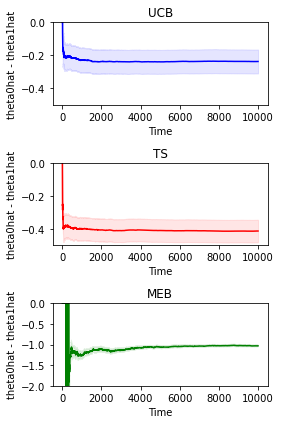

In [227]:
theta01_est_UCB = theta_est_UCB[:, 0, :, 0] - theta_est_UCB[:, 1, :, 0]        ## extract estimator of theta0-theta1 (first entry) over time for trajectories
theta01_est_TS = theta_est_TS[:, 0, :, 0] - theta_est_TS[:, 1, :, 0]
theta01_est_MEB = theta_est_MEB[:, 0, :, 0] - theta_est_MEB[:, 1, :, 0]

means_theta01_UCB = np.mean(theta01_est_UCB, axis=0)
ses_theta01_UCB = np.std(theta01_est_UCB, axis=0) / np.sqrt(n_experiment)
means_theta01_TS = np.mean(theta01_est_TS, axis=0)
ses_theta01_TS = np.std(theta01_est_TS, axis=0) / np.sqrt(n_experiment)
means_theta01_MEB = np.mean(theta01_est_MEB, axis=0)
ses_theta01_MEB = np.std(theta01_est_MEB, axis=0) / np.sqrt(n_experiment)

# Plot mean and se of the estimated theta0 for all the algorithms
fig, axes = plt.subplots(3, 1, figsize=(4, 6))

# Plot for UCB
axes[0].plot(np.arange(1, T+1), means_theta01_UCB[:], color='blue', alpha=1, label='Mean')
axes[0].fill_between(np.arange(1, T+1), means_theta01_UCB[:] - ses_theta01_UCB[:], \
                     means_theta01_UCB[:] + ses_theta01_UCB[:], color='blue', alpha=0.1)
axes[0].set_title('UCB')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('theta0hat - theta1hat')
axes[0].set_ylim((-0.5, 0))  # Set y-axis range

# Plot for TS
axes[1].plot(np.arange(1, T+1), means_theta01_TS[:], color='red', alpha=1, label='Mean')
axes[1].fill_between(np.arange(1, T+1), means_theta01_TS[:] - ses_theta01_TS[:], \
                     means_theta01_TS[:] + ses_theta01_TS[:], color='red', alpha=0.1)
axes[1].set_title('TS')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('theta0hat - theta1hat')
axes[1].set_ylim((-0.5, 0))  # Set y-axis range

# Plot for MEB
axes[2].plot(np.arange(1, T+1), means_theta01_MEB[:], color='green', alpha=1, label='Mean')
axes[2].fill_between(np.arange(1, T+1), means_theta01_MEB[:] - ses_theta01_MEB[:], \
                     means_theta01_MEB[:] + ses_theta01_MEB[:], color='green', alpha=0.1)
axes[2].set_title('MEB')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('theta0hat - theta1hat')
axes[2].set_ylim((-2, 0))  # Set y-axis range

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [228]:
# record weighted_theta_est for theta_0/theta_1
theta_0_est_batch_UCB = theta_est_batch_UCB[:, 0, :]
theta_0_est_batch_TS = theta_est_batch_TS[:, 0, :]
theta_0_est_batch_MEB = theta_est_batch_MEB[:, 0, :]

In [229]:
np.mean(theta_0_est_batch_UCB, axis=0)

array([-3.00931263])

In [230]:
print('Sample Mean and Cov of weighted theta estimators, data collected by UCB:')
print(np.mean(theta_0_est_batch_UCB, axis=0)[0], np.cov(theta_0_est_batch_UCB, rowvar=False))
print('Sample Mean and Cov of weighted theta estimators, data collected by TS:')
print(np.mean(theta_0_est_batch_TS, axis=0)[0], np.cov(theta_0_est_batch_TS, rowvar=False))
print('Sample Mean and Cov of weighted theta estimators, data collected by MEB:')
print(np.mean(theta_0_est_batch_MEB, axis=0)[0], np.cov(theta_0_est_batch_MEB, rowvar=False))

Sample Mean and Cov of weighted theta estimators, data collected by UCB:
-3.0093126320384203 0.0143717478573603
Sample Mean and Cov of weighted theta estimators, data collected by TS:
-3.022979705762915 0.013584330608463147
Sample Mean and Cov of weighted theta estimators, data collected by MEB:
-3.0101169260141436 0.010803413326255002


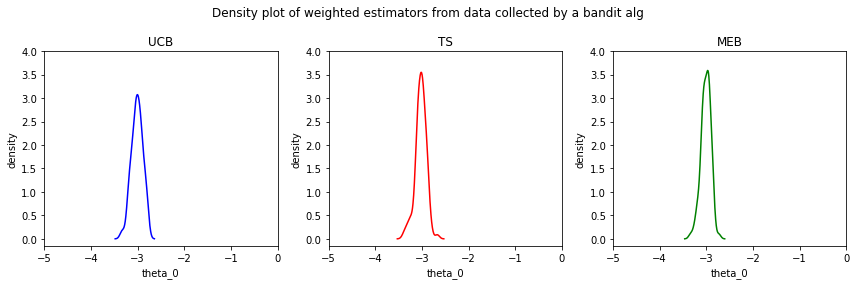

In [233]:
# draw histogram of weighted_theta_est
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# First subplot: density plot for UCB batch estimates
sns.kdeplot(theta_0_est_batch_UCB[:, 0], color="Blue", ax=axes[0])
axes[0].set_xlabel('theta_0')  # Set X axis label for first plot
axes[0].set_ylabel('density')  # Set Y axis label for first plot
axes[0].set_title('UCB')

# Second subplot: density plot for TS batch estimates
sns.kdeplot(theta_0_est_batch_TS[:, 0], color="Red", ax=axes[1])
axes[1].set_xlabel('theta_0')  # Set X axis label for first plot
axes[1].set_ylabel('density')  # Set Y axis label for first plot
axes[1].set_title('TS')

# 3rd subplot: density plot for MEB batch estimates
sns.kdeplot(theta_0_est_batch_MEB[:, 0], color="Green", ax=axes[2])
axes[2].set_xlabel('theta_0')  # Set X axis label for first plot
axes[2].set_ylabel('density')  # Set Y axis label for first plot
axes[2].set_title('MEB')

# Set same x and y axis limits for all subplots
x_limits = (-5, 0)  # Define x-axis limits
y_limits = (-0.15, 4)  # Define y-axis limits

for ax in axes:
    ax.set_xlim(x_limits)  # Set x-axis range
    ax.set_ylim(y_limits)  # Set y-axis range

# Add overall title and show the plots
plt.suptitle('Density plot of weighted estimators from data collected by a bandit alg')
plt.tight_layout()
plt.show()

simulation for 2d linear contextual bandit, test theta distribution

In [140]:
## simulation: test bandit behavior policy

T = 1000
d = 2
n_experiment = 1000
n_action = 2
theta = np.zeros((d, n_action))
theta[:, 0] = np.array([1., 0])
theta[:, 1] = np.array([1., 0])
sigma = 0.01
p_0 = 0.2
pi_nd = np.array([0.5, 0.5])

## option: sample x and e from a known discrete distribution
x_dict = np.array([[1., -3, -1, 3],[3, 1, -3, -1]]).T  ## true context uniformly drawn from this distribution
#x_dict = np.array([[0., -3, 0, 3],[3, 0, -3, 0]]).T  ## true context uniformly drawn from this distribution
l_e = 2.      ## scale parameter of the contextual noise
e_dict = l_e * np.array([[1., -1],[1, -1]]).T  ## contextual noise uniformly drawn from this distribution
Sigma_e = l_e ** 2 * np.array([[1., 1],[1, 1]])


theta_est_batch_UCB = np.zeros((n_experiment, n_action, d))
theta_est_batch_TS = np.zeros((n_experiment, n_action, d))
theta_est_batch_MEB = np.zeros((n_experiment, n_action, d))
for i_experiment in range(n_experiment):
    if (i_experiment % 10 == 0):
        print(i_experiment, end = ' ')
    Bandit_1 = LinBandit(theta = theta, sigma = sigma)
    
    # generate x_t and x_t_tilde
    x_list = np.zeros((T, d)) 
    x_tilde_list = np.zeros((T, d)) 
    for t in range(T):
        ## option: sample x and e from a known discrete distribution
        x_idx = np.random.randint(0, 4)
        x_t = x_dict[x_idx, :]
        e_idx = np.random.randint(0, 2)
        e_t = e_dict[e_idx, :]
        x_tilde_t = x_t + e_t
        x_list[t, :] = x_t
        x_tilde_list[t, :] = x_tilde_t
    
    # generate potential outcomes table
    Bandit_info = Bandit_1.generate_potential_reward_history_list_w_xtilde(x_list = x_list, \
                                                                           x_tilde_list = x_tilde_list)
    
    # run bandit algorithms
    C = 1.0
    UCB_history = Bandit_1.UCB_w_predicted_state(x_list = x_list,
                                                 x_tilde_list = x_tilde_list, \
                                                 potential_reward_list = Bandit_info['potential_reward_list'], \
                                                 at_dag_list = Bandit_info['at_dag_list'], \
                                                 C = C, l = 1., p_0 = p_0)
    TS_history = Bandit_1.TS_w_predicted_state(x_list = x_list,
                                               x_tilde_list = x_tilde_list, \
                                               potential_reward_list = Bandit_info['potential_reward_list'], \
                                               at_dag_list = Bandit_info['at_dag_list'], \
                                               rho2 = sigma ** 2, l = 1., p_0 = p_0)
    
    ## construct parameters for MEB
    ind_S = (np.arange(T) > 100)
    pi_nd_list = 0.5 * np.ones((T, n_action))
    Sigma_e_hat_list = np.zeros((T, d, d))
    for t in range(T):
        Sigma_e_hat_list[t, :, :] = Sigma_e
    MEB_history = Bandit_1.online_me_adjust_w_predicted_state(x_list = x_list, x_tilde_list = x_tilde_list, \
                                                              potential_reward_list = Bandit_info['potential_reward_list'],  
                                                              at_dag_list = Bandit_info['at_dag_list'],\
                                                              Sigma_e_hat_list = Sigma_e_hat_list, \
                                                              ind_S = ind_S, 
                                                              pi_nd_list = pi_nd_list, \
                                                              p_0 = p_0, naive = False)
    
    # get weighted_theta_est
    theta_est_UCB_results = weighted_theta_est(history = UCB_history, \
                                               pi_nd = pi_nd, \
                                               Sigma_e = Sigma_e)
    theta_est_batch_UCB[i_experiment, :, :] = theta_est_UCB_results['theta_est_batch']
    theta_est_TS_results = weighted_theta_est(history = TS_history, \
                                              pi_nd = pi_nd, \
                                              Sigma_e = Sigma_e)
    theta_est_batch_TS[i_experiment, :, :] = theta_est_TS_results['theta_est_batch']
    theta_est_MEB_results = weighted_theta_est(history = MEB_history, \
                                              pi_nd = pi_nd, \
                                              Sigma_e = Sigma_e)
    theta_est_batch_MEB[i_experiment, :, :] = theta_est_MEB_results['theta_est_batch']


0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 

In [141]:
# record weighted_theta_est for theta_0/theta_1
theta_0_est_batch_UCB = theta_est_batch_UCB[:, 0, :]
theta_0_est_batch_TS = theta_est_batch_TS[:, 0, :]
theta_0_est_batch_MEB = theta_est_batch_MEB[:, 0, :]

In [142]:
np.max(theta_0_est_batch_UCB)

1.217337189350267

In [143]:
print('Sample Cov of weighted theta estimators, data collected by UCB:')
print(np.cov(theta_0_est_batch_UCB, rowvar=False))
print('Sample Cov of weighted theta estimators, data collected by TS:')
print(np.cov(theta_0_est_batch_TS, rowvar=False))
print('Sample Cov of weighted theta estimators, data collected by MEB:')
print(np.cov(theta_0_est_batch_MEB, rowvar=False))

Sample Cov of weighted theta estimators, data collected by UCB:
[[0.00310743 0.000383  ]
 [0.000383   0.00273987]]
Sample Cov of weighted theta estimators, data collected by TS:
[[0.00289376 0.0002411 ]
 [0.0002411  0.00270733]]
Sample Cov of weighted theta estimators, data collected by MEB:
[[0.00285658 0.00025073]
 [0.00025073 0.00263663]]


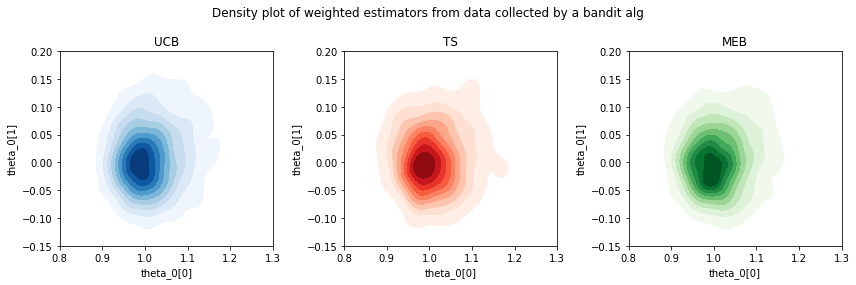

In [144]:
# draw histogram of weighted_theta_est
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# First subplot: 2D density plot for UCB batch estimates
sns.kdeplot(x=theta_0_est_batch_UCB[:, 0], y=theta_0_est_batch_UCB[:, 1], fill=True, cmap="Blues", ax=axes[0])
axes[0].set_xlabel('theta_0[0]')  # Set X axis label for first plot
axes[0].set_ylabel('theta_0[1]')  # Set Y axis label for first plot
axes[0].set_title('UCB')

# Second subplot: 2D density plot for TS batch estimates
sns.kdeplot(x=theta_0_est_batch_TS[:, 0], y=theta_0_est_batch_TS[:, 1], fill=True, cmap="Reds", ax=axes[1])
axes[1].set_xlabel('theta_0[0]')  # Set X axis label for first plot
axes[1].set_ylabel('theta_0[1]')  # Set Y axis label for first plot
axes[1].set_title('TS')

# 3rd subplot: 2D density plot for MEB batch estimates
sns.kdeplot(x=theta_0_est_batch_MEB[:, 0], y=theta_0_est_batch_MEB[:, 1], fill=True, cmap="Greens", ax=axes[2])
axes[2].set_xlabel('theta_0[0]')  # Set X axis label for first plot
axes[2].set_ylabel('theta_0[1]')  # Set Y axis label for first plot
axes[2].set_title('MEB')

# Set same x and y axis limits for all subplots
x_limits = (0.8, 1.3)  # Define x-axis limits
y_limits = (-0.15, 0.2)  # Define y-axis limits

for ax in axes:
    ax.set_xlim(x_limits)  # Set x-axis range
    ax.set_ylim(y_limits)  # Set y-axis range

# Add overall title and show the plots
plt.suptitle('Density plot of weighted estimators from data collected by a bandit alg')
plt.tight_layout()
plt.show()

A counterexample where naive UCB and TS leads to linear regret, even Ass. 2.3 is satisfied

In [5]:
## simulation: construct bandit instance, compare estimation and regret of proposed algorithm and TS
T = 10000
d = 2
n_experiment = 100
n_action = 2
theta = np.zeros((d, n_action))
theta[:, 0] = np.array([1., 0])
theta[:, 1] = np.array([-1., 0])
sigma = 0.01
#Sigma_e = 1./4 * np.eye(d) ## not used
#Sigma_e_list = np.zeros((T, d, d)) ## not used
#for t in range(T):
#    Sigma_e_list[t, :, :] = Sigma_e
p_0 = 0.2

UCB_estimation_err_sum = np.zeros((T, n_action))
UCB_estimation_err_sum2 = np.zeros((T, n_action))
UCB_regret_err_sum = np.zeros(T)
UCB_regret_err_sum2 = np.zeros(T)
TS_estimation_err_sum = np.zeros((T, n_action))
TS_estimation_err_sum2 = np.zeros((T, n_action))
TS_regret_err_sum = np.zeros(T)
TS_regret_err_sum2 = np.zeros(T)

x_dict = np.array([[1, -3, -1, 3],[3, 1, -3, -1]]).T

for i_experiment in range(n_experiment):
    print(i_experiment, end = ' ')
    Bandit_1 = LinBandit(theta = theta, sigma = sigma)
    ## iid x_t
    x_list = np.zeros((T, d)) 
    for t in range(T):
        x_idx = np.random.randint(0, 4)
        x_list[t, :] = x_dict[x_idx, :]
    
    Bandit_info = Bandit_1.generate_potential_reward_history_list1(x_list = x_list, rho = 0.9)
    #print('data generated')

    C = 1.0
    UCB_history = Bandit_1.UCB_w_predicted_state(x_list = x_list,
                                                 x_tilde_list = Bandit_info['x_tilde_list'], \
                                                 potential_reward_list = Bandit_info['potential_reward_list'], \
                                                 at_dag_list = Bandit_info['at_dag_list'], \
                                                 C = C, l = 1., p_0 = p_0)
    TS_history = Bandit_1.TS_w_predicted_state(x_list = x_list,
                                               x_tilde_list = Bandit_info['x_tilde_list'], \
                                               potential_reward_list = Bandit_info['potential_reward_list'], \
                                               at_dag_list = Bandit_info['at_dag_list'], \
                                               rho2 = sigma ** 2, l = 1., p_0 = p_0)
    
    UCB_estimation_err_sum = UCB_estimation_err_sum + UCB_history['estimation_err_list']
    UCB_estimation_err_sum2 = UCB_estimation_err_sum2 + UCB_history['estimation_err_list'] ** 2
    UCB_regret_err_sum = UCB_regret_err_sum + UCB_history['regret_list']
    UCB_regret_err_sum2 = UCB_regret_err_sum2 + UCB_history['regret_list'] ** 2
    TS_estimation_err_sum = TS_estimation_err_sum + TS_history['estimation_err_list']
    TS_estimation_err_sum2 = TS_estimation_err_sum2 + TS_history['estimation_err_list'] ** 2
    TS_regret_err_sum = TS_regret_err_sum + TS_history['regret_list']
    TS_regret_err_sum2 = TS_regret_err_sum2 + TS_history['regret_list'] ** 2

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [6]:
UCB_history['theta_est_list'][0, :, :] - UCB_history['theta_est_list'][1, :, :]

array([[ 0.        ,  0.        ],
       [ 0.06118129, -0.75456921],
       [ 0.12231343, -1.50853228],
       ...,
       [ 1.3782704 , -0.611232  ],
       [ 1.37827362, -0.61116096],
       [ 1.37823703, -0.61107253]])

In [7]:
UCB_estimation_err_sum.shape

(10000, 2)

(0.0, 1.0)

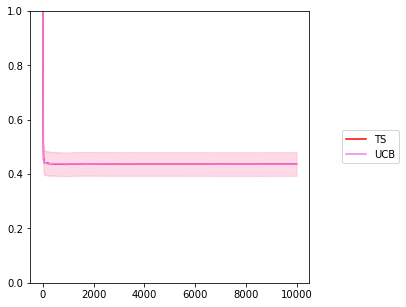

In [9]:
# plot estimation error (theta_1)
fig, ax = plt.subplots(figsize=(5, 5))
#ax.fill_between(x, y0-y0_std, y0+y0_std, color = 'green', alpha=0.2)
TS_est_1_mean = TS_estimation_err_sum[:, 1] / n_experiment
TS_est_1_sd = (TS_estimation_err_sum2[:, 1] - TS_est_1_mean ** 2) ** 0.5 / (n_experiment)
UCB_est_1_mean = UCB_estimation_err_sum[:, 1] / n_experiment
UCB_est_1_sd = (UCB_estimation_err_sum2[:, 1] - UCB_est_1_mean ** 2) ** 0.5 / (n_experiment)
ax.plot(np.arange(T), TS_est_1_mean, color = 'red', markersize=0.2, label = 'TS')
ax.plot(np.arange(T), UCB_est_1_mean, color = 'violet', markersize=0.2, label = 'UCB')
ax.fill_between(np.arange(T), TS_est_1_mean - TS_est_1_sd, \
                TS_est_1_mean + TS_est_1_sd, color = 'red', alpha=0.1)
ax.fill_between(np.arange(T), UCB_est_1_mean - UCB_est_1_sd, \
                UCB_est_1_mean + UCB_est_1_sd, color = 'violet', alpha=0.1)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
#ax.set_xlim([0, 10000])
#ax.set_xticks([0, 5000, 10000, 15000, 20000])
ax.set_ylim([0, 1])
#fig.savefig("7.pdf", format="pdf")

(0.0, 1.0)

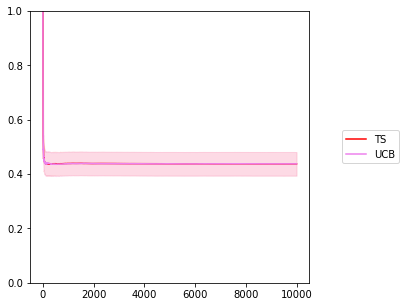

In [10]:
# plot estimation error (theta_0)
fig, ax = plt.subplots(figsize=(5, 5))
#ax.fill_between(x, y0-y0_std, y0+y0_std, color = 'green', alpha=0.2)
TS_est_0_mean = TS_estimation_err_sum[:, 0] / n_experiment
TS_est_0_sd = (TS_estimation_err_sum2[:, 0] - TS_est_0_mean ** 2) ** 0.5 / (n_experiment)
UCB_est_0_mean = UCB_estimation_err_sum[:, 0] / n_experiment
UCB_est_0_sd = (UCB_estimation_err_sum2[:, 0] - UCB_est_0_mean ** 2) ** 0.5 / (n_experiment)
ax.plot(np.arange(T), TS_est_0_mean, color = 'red', markersize=0.2, label = 'TS')
ax.plot(np.arange(T), UCB_est_0_mean, color = 'violet', markersize=0.2, label = 'UCB')
ax.fill_between(np.arange(T), TS_est_0_mean - TS_est_0_sd, \
                TS_est_0_mean + TS_est_0_sd, color = 'red', alpha=0.1)
ax.fill_between(np.arange(T), UCB_est_0_mean - UCB_est_0_sd, \
                UCB_est_0_mean + UCB_est_0_sd, color = 'violet', alpha=0.1)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
#ax.set_xlim([0, 10000])
#ax.set_xticks([0, 5000, 10000, 15000, 20000])
ax.set_ylim([0, 1])
#fig.savefig("7.pdf", format="pdf")

In [11]:
TS_est_0_mean

array([1.        , 0.9856095 , 0.95660385, ..., 0.43754418, 0.43754841,
       0.43755095])

In [12]:
TS_est_1_mean

array([1.        , 0.92636405, 0.87044548, ..., 0.43692377, 0.4369183 ,
       0.43691462])

(0.0, 6000.0)

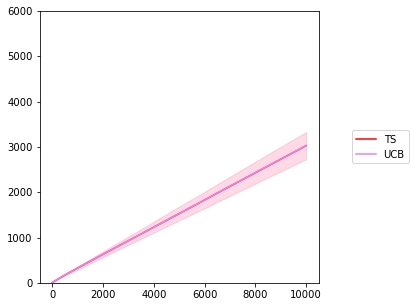

In [13]:
# plot regret
fig, ax = plt.subplots(figsize=(5, 5))
UCB_regret_mean = UCB_regret_err_sum / n_experiment
UCB_regret_sd = (UCB_regret_err_sum2 - UCB_regret_mean ** 2) ** 0.5 / (n_experiment)
TS_regret_mean = TS_regret_err_sum / n_experiment
TS_regret_sd = (TS_regret_err_sum2 - TS_regret_mean ** 2) ** 0.5 / (n_experiment)
#ME_regret_mean = ME_regret_err_sum / n_experiment
#ME_regret_sd = (ME_regret_err_sum2 - ME_regret_mean ** 2) ** 0.5 / (n_experiment)
#ME_n_regret_mean = ME_n_regret_err_sum / n_experiment
#ME_n_regret_sd = (ME_n_regret_err_sum2 - ME_n_regret_mean ** 2) ** 0.5 / (n_experiment)
#ax.plot(np.arange(T), ME_regret_err_sum / n_experiment, color = 'blue', markersize=0.2, label = 'MEB')
#ax.plot(np.arange(T), ME_n_regret_err_sum / n_experiment, color = 'green', markersize=0.2, label = 'MEB_naive')
ax.plot(np.arange(T), TS_regret_mean, color = 'red', markersize=0.2, label = 'TS')
ax.plot(np.arange(T), UCB_regret_mean, color = 'violet', markersize=0.2, label = 'UCB')
#ax.fill_between(np.arange(T), ME_regret_mean - ME_regret_sd, \
#                ME_regret_mean + ME_regret_sd, color = 'blue', alpha=0.1)
#ax.fill_between(np.arange(T), ME_n_regret_mean - ME_n_regret_sd, \
#                ME_n_regret_mean + ME_n_regret_sd, color = 'green', alpha=0.1)
ax.fill_between(np.arange(T), TS_regret_mean - TS_regret_sd, \
                TS_regret_mean + TS_regret_sd, color = 'red', alpha=0.1)
ax.fill_between(np.arange(T), UCB_regret_mean - UCB_regret_sd, \
                UCB_regret_mean + UCB_regret_sd, color = 'violet', alpha=0.1)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
#ax.set_xlim([0, 20000])
#ax.set_xticks([0, 5000, 10000, 15000, 20000])
#ax.set_xlim([0, 10000])
#ax.set_xticks([0, 2500, 5000, 7500, 10000])
#ax.set_xlim([0, 10000])
#ax.set_xticks([0, 2500, 5000, 7500, 10000])
ax.set_ylim([0, 6000])
#fig.savefig("8.pdf", format="pdf")

In [17]:
np.mean(UCB_history['at_list'] != UCB_history['at_dag_list'])

0.05725885482290354

In [18]:
print(TS_est_1_mean[-1], TS_est_1_sd[-1])
print(ME_est_1_mean[-1], ME_est_1_sd[-1])
print(ME_n_est_1_mean[-1], ME_n_est_1_sd[-1])

0.00953130966478182 0.0030226257632393547
0.001432803780325856 0.00046066716311827475
0.004916243975077221 0.0015896085612874683


In [19]:
print(TS_regret_mean[-1], TS_regret_sd[-1])
print(ME_regret_mean[-1], ME_regret_sd[-1])
print(ME_n_regret_mean[-1], ME_n_regret_sd[-1])

1.4970634701129981 0.48050701951340796
2.6064130978591264 0.8423614527617207
6.836600049914643 2.2154570557423474
